In [1]:
sc.install_pypi_package( "pandas==1.0.4" )
sc.install_pypi_package( "matplotlib==3.2.1" )
sc.install_pypi_package("imblearn==0.0")
sc.install_pypi_package("scikit-learn==0.23.1")
sc.install_pypi_package("sklearn==0.0")
sc.install_pypi_package("boto3==1.13")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1593699747412_0001,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…





  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: /var/lib/livy/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
import sys
import pandas as pd
from pyspark.sql import SparkSession
# create sparksession
spark = SparkSession \
    .builder \
    .appName("insight") \
    .getOrCreate()
acquis_q1 = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q1/Acquisition_2010Q1.txt")
acquis_q2 = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q2/Acquisition_2010Q2.txt")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
acquis = acquis_q1.union(acquis_q2)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
perf_q1 = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q1/Performance_2010Q1.txt")
perf_q2 = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q2/Performance_2010Q2.txt")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
perf = perf_q1.union(perf_q2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
col_names_aquisition = ['loanID', 'originationChannel', 'sellerName', 'origIntRate', 'origUPB', 
                       'origLoanTerm', 'originationDate', 'firstPaymentDate', 'LTV', 'CLTV', 
                        'numOfBorrowers', 'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
                       'firstTimeBuyerIndicator', 'loanPurpose', 'propertyType', 'numOfUnits',
                       'occupancyType', 'propertyState', 'zipCodeShort', 'primaryMortgInsurPercent', 
                       'productType', 'coborrowerCreditScoreAtOrig', 'mortgageInsurType', 
                       'relocationMortgIndicator']
col_names_performance =['loanID', 'monthlyReportingPeriod', 'servicerName', 'currentIntRate',
                       'currentActualUPB', 'loanAge', 'remMonthsToLegalMaturity', 'adjMonthToMaturity',
                       'maturityDate', 'MSA', 'currentLoanDelinqStatus', 'modifFlag', 'zeroBalanceCode',
                       'zeroBalanceEffectiveDate', 'lastPaidInstallDate', 'foreclosureDate',
                       'dispositionDate', 'foreclosureCost', 'propPreservAndReparCosts', 'assetRecoveryCosts',
                       'miscelHoldingExpensesAndCredits', 'associatedTaxesForHoldingProperty', 'netSaleProceeds',
                       'creditEnhacementProceeds', 'repurchaseMakeWholeProceeds','otherForeclosureProceeds',
                       'nonInterestBearingUPB', 'principalForegivenessAmount', 'repurchaseMakeWholeProceedsFlag',
                       'foreclosurePrincipWriteOffAmont', 'servicingActivityIndicator']



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.sql.functions import col
#acquis_rn.where(col('loanID')==100019943199).show()
#perf_rn.where(col('loanID')==100446401716).select(['loanID', 'modifFlag','monthlyReportingPeriod','zeroBalanceCode', 'currentLoanDelinqStatus', 'foreclosureDate']).show(50)
#perf_rn.where(col('currentLoanDelinqStatus').isNull()).select(['loanID', 'monthlyReportingPeriod','zeroBalanceCode', 'currentLoanDelinqStatus']).show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:

i = 0
acquis_rn = acquis
for colname in col_names_aquisition:
    acquis_rn = acquis_rn.withColumnRenamed("_c"+str(i),col_names_aquisition[i])
    i = i + 1
    
i = 0
perf_rn = perf
for colname in col_names_performance:
    perf_rn = perf_rn.withColumnRenamed("_c"+str(i),col_names_performance[i])
    i = i + 1
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import IntegerType
perf_rn = perf_rn.withColumn("monthlyReportingPeriod",to_date(perf_rn.monthlyReportingPeriod,'MM/dd/yyyy'))
perf_rn = perf_rn.withColumn("zeroBalanceEffectiveDate",to_date(perf_rn.zeroBalanceEffectiveDate,'MM/yyyy'))
perf_rn = perf_rn.withColumn("currentLoanDelinqStatus", perf_rn["currentLoanDelinqStatus"].cast(IntegerType()))
acquis_rn = acquis_rn.withColumn("originationDate",to_date(acquis_rn.originationDate,'MM/yyyy'))
acquis_rn = acquis_rn.withColumn("firstPaymentDate",to_date(acquis_rn.firstPaymentDate,'MM/yyyy'))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
perf_rn.createOrReplaceTempView('perf')
_2010Q1_perf_Dec2010 = spark.sql(
'''
SELECT 
perf.loanID, perf.monthlyReportingPeriod, perf.zeroBalanceCode, perf.currentLoanDelinqStatus FROM perf 
WHERE perf.monthlyReportingPeriod <= "2010-12-01"
'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
perf_rn.createOrReplaceTempView('perf')
_2010Q1_perf_2019 = spark.sql(
'''
SELECT 
perf.loanID, perf.monthlyReportingPeriod, perf.zeroBalanceCode, perf.currentLoanDelinqStatus FROM perf 

'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
classes_2019 = _2010Q1_perf_2019.groupBy("loanID").max("zeroBalanceCode").withColumnRenamed("max(zeroBalanceCode)", "code")
classes_Dec2010 = _2010Q1_perf_Dec2010.groupBy("loanID").max("zeroBalanceCode").withColumnRenamed("max(zeroBalanceCode)", "code")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
from pyspark.sql.functions import when, col

classes10 = classes_Dec2010.withColumn("code", when(classes_Dec2010.code.isNull(), 0).otherwise(classes_Dec2010.code))
classes10.groupBy("code").count().sort("code").show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0|606511|
|   1| 50740|
|   2|     1|
|   3|     4|
|   6|    86|
|   9|     9|
+----+------+

In [14]:
classes19 = classes_2019.withColumn("code", when(classes_2019.code.isNull(), 0).otherwise(classes_2019.code))
classes19.groupBy("code").count().sort("code").show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0|113243|
|   1|539674|
|   2|   478|
|   3|   467|
|   6|   591|
|   9|  2143|
|  15|   329|
|  16|   453|
+----+------+

In [15]:
classes10 = classes10.filter((classes10.code!= 2) & (classes10.code!= 3) & (classes10.code!= 6) & (classes10.code!= 9))
classes10.groupBy("code").count().sort("code").show(20)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0|606511|
|   1| 50740|
+----+------+

In [16]:
classes19 = classes19.filter((classes19.code!= 0) & (classes19.code!= 1) & (classes19.code!= 6) & (classes19.code!= 15) & (classes19.code!= 16))
classes19.groupBy("code").count().sort("code").show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+
|code|count|
+----+-----+
|   2|  478|
|   3|  467|
|   9| 2143|
+----+-----+

In [17]:
classes = classes19.union(classes10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
classes=classes.replace((2,3),9)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
classes_union= classes.dropDuplicates(['loanID'])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
classes_union.groupBy("code").count().sort("code").show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0|604567|
|   1| 50740|
|   9|  1959|
+----+------+

In [21]:
acquis_rn.createOrReplaceTempView('acquis')
sql_acquis = spark.sql(
'''
SELECT acquis.loanID, acquis.originationChannel, acquis.sellerName, acquis.origIntRate, acquis.origUPB, acquis.originationDate, 
acquis.firstPaymentDate, acquis.LTV, acquis.CLTV, acquis.numOfBorrowers, acquis.origDebtToIncomeRatio, 
acquis.borrowerCredScoreAtOrigination, acquis.firstTimeBuyerIndicator, acquis.loanPurpose, acquis.propertyType, 
acquis.numOfUnits, acquis.zipCodeShort, acquis.primaryMortgInsurPercent, acquis.productType, acquis.mortgageInsurType
FROM acquis

'''
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
_2010Q1 = sql_acquis.join(classes_union,on=['loanID'],how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:

df1 = _2010Q1.groupBy("code").count().sort("code")
df1.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0|604107|
|   1| 50740|
|   9|  2419|
+----+------+

In [24]:
drop1= ['primaryMortgInsurPercent', 'mortgageInsurType']
_2010Q1 = _2010Q1.drop(*drop1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
_cols = _2010Q1.columns
_2010Q1_cleaned = _2010Q1
for _c in _cols:
    _2010Q1_cleaned = _2010Q1_cleaned.filter(_2010Q1_cleaned[_c]. isNotNull())
print(_2010Q1_cleaned.count(), len(_2010Q1_cleaned.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

652897 19

In [26]:
df1 = _2010Q1_cleaned.groupBy("code").count().sort("code")
df1.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0|600304|
|   1| 50398|
|   9|  2195|
+----+------+

In [27]:
print(_2010Q1_cleaned.count(), len(_2010Q1_cleaned.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

652897 19

In [28]:
_2010Q1_cleaned.select(_2010Q1_cleaned.columns[0:8]).show(7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------------+--------------------+-----------+-------+---------------+----------------+---+
|      loanID|originationChannel|          sellerName|origIntRate|origUPB|originationDate|firstPaymentDate|LTV|
+------------+------------------+--------------------+-----------+-------+---------------+----------------+---+
|100044841710|                 B|               OTHER|        5.0| 358000|     2010-05-01|      2010-07-01| 80|
|100056029701|                 C|WELLS FARGO BANK,...|       4.25| 103000|     2009-12-01|      2010-02-01| 80|
|100121471669|                 B|               OTHER|        5.5| 182000|     2010-02-01|      2010-04-01| 70|
|100133349871|                 R|               OTHER|      4.875| 160000|     2009-09-01|      2009-11-01| 80|
|100156485730|                 R|               OTHER|        5.0|  90000|     2010-02-01|      2010-04-01| 80|
|100207945740|                 R|JPMORGAN CHASE BA...|       4.99|  76000|     2010-01-01|      2010-03-

In [29]:
_2010Q1_cleaned.select("numOfUnits").groupBy("numOfUnits").count().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+
|numOfUnits| count|
+----------+------+
|         1|637025|
|         3|  2214|
|         4|  2206|
|         2| 11452|
+----------+------+

In [30]:
drop2=["loanID","originationDate", "firstPaymentDate"]
_2010Q1_cleaned = _2010Q1_cleaned.drop(*drop2) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
from imblearn.over_sampling import SMOTENC
from collections import Counter
_2010Q1_cleanedPandas =_2010Q1_cleaned.toPandas()

_2010Q1_cleanedPandas["LTV_square"] = _2010Q1_cleanedPandas['LTV']**2
_2010Q1_cleanedPandas["numOfBorrowers_square"] = _2010Q1_cleanedPandas['numOfBorrowers']**2
_2010Q1_cleanedPandas["CLTV_square"] = _2010Q1_cleanedPandas['CLTV']**2
_2010Q1_cleanedPandas["origUPB_square"] = _2010Q1_cleanedPandas['origUPB']**2

y_to_resample = _2010Q1_cleanedPandas['code']
X_to_resample = _2010Q1_cleanedPandas.drop(['code'], axis=1)
#smote_nc = SMOTENC(categorical_features=[0, 1, 9, 10, 11,14], random_state=0)
#X_resampled, y_resampled = smote_nc.fit_resample(X_to_resample, y_to_resample)
#print(sorted(Counter(y_resampled).items()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
a=_2010Q1_cleaned.toPandas()
a.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652897 entries, 0 to 652896
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   originationChannel              652897 non-null  object 
 1   sellerName                      652897 non-null  object 
 2   origIntRate                     652897 non-null  float64
 3   origUPB                         652897 non-null  int32  
 4   LTV                             652897 non-null  int32  
 5   CLTV                            652897 non-null  int32  
 6   numOfBorrowers                  652897 non-null  int32  
 7   origDebtToIncomeRatio           652897 non-null  int32  
 8   borrowerCredScoreAtOrigination  652897 non-null  int32  
 9   firstTimeBuyerIndicator         652897 non-null  object 
 10  loanPurpose                     652897 non-null  object 
 11  propertyType                    652897 non-null  object 
 12  numOfUnits      

In [33]:
sns.pairplot(X_to_resample.iloc[:, 2:], hue="Class")
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'sns' is not defined
Traceback (most recent call last):
NameError: name 'sns' is not defined



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

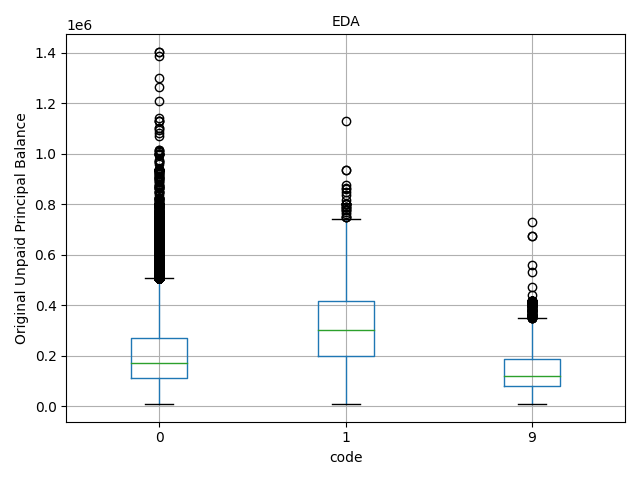

In [34]:
import matplotlib.pyplot as plt

_2010Q1_cleanedPandas.boxplot(column='origUPB', by='code')
plt.suptitle('')
plt.title("EDA", fontsize=10)
plt.ylabel("Original Unpaid Principal Balance", fontsize=10)
plt.tight_layout()
%matplot plt

In [35]:
print(sorted(Counter(y_to_resample).items()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, 601037), (1, 50398), (9, 1462)]

In [36]:
X1_droped = X_to_resample.drop(['productType'], axis=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
X1_droped.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652897 entries, 0 to 652896
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   originationChannel              652897 non-null  object 
 1   sellerName                      652897 non-null  object 
 2   origIntRate                     652897 non-null  float64
 3   origUPB                         652897 non-null  int32  
 4   LTV                             652897 non-null  int32  
 5   CLTV                            652897 non-null  int32  
 6   numOfBorrowers                  652897 non-null  int32  
 7   origDebtToIncomeRatio           652897 non-null  int32  
 8   borrowerCredScoreAtOrigination  652897 non-null  int32  
 9   firstTimeBuyerIndicator         652897 non-null  object 
 10  loanPurpose                     652897 non-null  object 
 11  propertyType                    652897 non-null  object 
 12  numOfUnits      

In [38]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

rng = np.random.RandomState(seed=42)


categorical_columns = ['originationChannel', 'sellerName', 'firstTimeBuyerIndicator',
                       'loanPurpose', 'propertyType']
numerical_columns = ['origIntRate', 'origUPB', 'LTV', 'CLTV', 'numOfBorrowers',
                    'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination','numOfUnits', 'zipCodeShort',
                    'LTV_square', 'numOfBorrowers_square', 'CLTV_square', 'origUPB_square']


X1 = X1_droped[categorical_columns + numerical_columns]
y1=y_to_resample

#spliting of data into test and train
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, stratify=y1, test_size = 0.25, random_state=42)

over = RandomOverSampler(sampling_strategy={9:3000})
X1_train, y1_train = over.fit_resample(X1_train, y1_train)

under = RandomUnderSampler(sampling_strategy={0:3000, 1:3000})
X1_train, y1_train = under.fit_resample(X1_train, y1_train)

#pipeline for one-hot encoding of categorical features
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#imputer in case value is missing from numerical feature
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
#processing data
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])
#setting up the model
rf1 = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',  RandomForestClassifier(random_state=42, n_estimators=100, max_features= 14))
])

#GradientBoostingClassifier(n_estimators=2000, learning_rate=1.0,
                                              #max_features = 10, min_samples_leaf = 20, random_state=42
#svm.SVC(kernel='poly', degree=3, gamma='auto', C=0.5)
#svm.NuSVC(kernel="poly", degree= 4)
#neighbors.KNeighborsClassifier(n_neighbors=2, weights="distance", n_jobs=-1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
rf1.fit(X1_train, y1_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['originationChannel',
                                                   'sellerName',
                                                   'firstTimeBuyerIndicator',
                                                   'loanPurpose',
                                                   'propertyType']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['origIntRate', 'origUPB',
                                                   'LTV', 'CLTV',
         

In [40]:
print("RF train accuracy: %0.3f" % rf1.score(X1_train, y1_train))
print("RF test accuracy: %0.3f" % rf1.score(X1_test, y1_test))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RF train accuracy: 1.000
RF test accuracy: 0.603

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

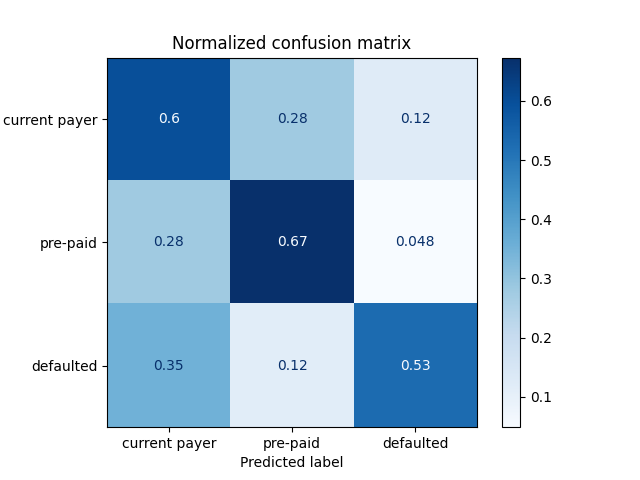

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
class_names = ["current payer","pre-paid","defaulted"]
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf1, X1_test, y1_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

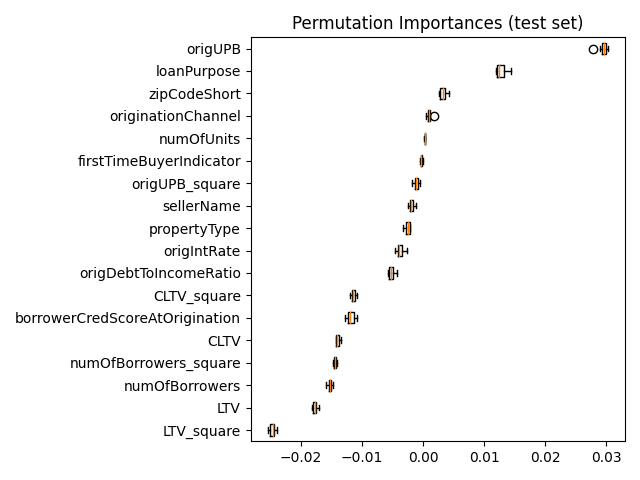

In [42]:
import matplotlib
import matplotlib.pyplot as plt

result = permutation_importance(rf1, X1_test, y1_test.to_numpy(), n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X1_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
%matplot plt

In [43]:
# sending compressed random forest model to AWS S3 for use in the streamlit app
#import tempfile
#import boto3
#import joblib
#bucket_name = "mortgagemodel"
#key = "model3rf.pkl"
#client = boto3.client('s3')
#client.create_bucket(Bucket=bucket_name)
#with tempfile.TemporaryFile() as fp:
    #joblib.dump(rf1, fp)
    #fp.seek(0)
    #client.put_object(Body=fp.read(), Bucket=bucket_name, Key=key)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…